In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import moviepy.editor
import os
import pickle
import json

In [25]:
data_id = 'cat'
params = json.load(open(f"mocap_dataset/{data_id}/params.json"))
PEN_LENGTH, CANVAS_MIN_HEIGHT, CANVAS_MAX_HEIGHT = params['pen_length'], params['canvas_min_z'], params['canvas_max_z']

In [26]:
def read_mocap_csv(fname):
    with open(fname) as f:
        # Ignore first 6 lines (header) and only take first 23 columns
        df = pd.read_csv(f, skiprows=6, usecols=range(23))

        # Rename columns
        df.columns = [
            'frame',
            'time',
            'canvas_1_x',
            'canvas_1_y',
            'canvas_1_z',
            'canvas_2_x',
            'canvas_2_y',
            'canvas_2_z',
            'canvas_3_x',
            'canvas_3_y',
            'canvas_3_z',
            'pen_1_x',
            'pen_1_y',
            'pen_1_z',
            'pen_2_x',
            'pen_2_y',
            'pen_2_z',
            'pen_3_x',
            'pen_3_y',
            'pen_3_z',
            'pen_4_x',
            'pen_4_y',
            'pen_4_z',
        ]
        return df

df = read_mocap_csv(f"mocap_dataset/{data_id}/mocap.csv")
df.head()

,frame,time,canvas_1_x,canvas_1_y,canvas_1_z,canvas_2_x,canvas_2_y,canvas_2_z,canvas_3_x,canvas_3_y,...,pen_1_z,pen_2_x,pen_2_y,pen_2_z,pen_3_x,pen_3_y,pen_3_z,pen_4_x,pen_4_y,pen_4_z
0,0,0.000,-1242.406128,1120.179932,-82.603493,-1162.139282,1124.170776,145.097412,-1422.403564,1127.314087,...,322.234467,-1353.352905,1182.328735,295.426331,-1311.341064,1183.157715,322.112823,-1344.163940,1156.861084,348.709229
1,1,0.004,-1240.992920,1120.444824,-82.406929,-1160.864990,1124.088989,145.255859,-1421.028320,1127.518921,...,321.993195,-1352.357788,1182.375610,295.490173,-1310.462280,1183.136108,322.170959,-1343.232544,1156.809448,348.700623
2,2,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.013,-1238.093506,1120.888184,-82.276787,-1158.599121,1124.089722,145.697311,-1418.200317,1128.123169,...,321.844391,-1350.439331,1182.319458,295.397095,-1308.620972,1183.145142,322.278076,-1341.459351,1156.804565,348.859894
4,4,0.017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
idxs = []
states = []
for i in range(len(df)):
    canvas_1 = np.array([df['canvas_1_x'][i], df['canvas_1_y'][i], df['canvas_1_z'][i]])
    canvas_2 = np.array([df['canvas_2_x'][i], df['canvas_2_y'][i], df['canvas_2_z'][i]])
    canvas_3 = np.array([df['canvas_3_x'][i], df['canvas_3_y'][i], df['canvas_3_z'][i]])
    pen_1 = np.array([df['pen_1_x'][i], df['pen_1_y'][i], df['pen_1_z'][i]])
    pen_2 = np.array([df['pen_2_x'][i], df['pen_2_y'][i], df['pen_2_z'][i]])
    pen_3 = np.array([df['pen_3_x'][i], df['pen_3_y'][i], df['pen_3_z'][i]])
    pen_4 = np.array([df['pen_4_x'][i], df['pen_4_y'][i], df['pen_4_z'][i]])

    state = np.array([canvas_1, canvas_2, canvas_3, pen_1, pen_2, pen_3, pen_4]) / 1000 # scale mm to m
    if np.isnan(state).any():
        continue
    idxs.append(i)
    states.append(state)
states = np.array(states)

In [28]:
# Calculate centroid of each pen position (average of the 4 pen markers)
pen_centroids_x = np.mean(states[:,3:,0], axis=1)
pen_centroids_y = np.mean(states[:,3:,1], axis=1)
pen_centroids_z = np.mean(states[:,3:,2], axis=1)
pen_centroids = np.stack([pen_centroids_x, pen_centroids_y, pen_centroids_z], axis=1) # (N, 3)

# Estimate pen radius
distances = np.linalg.norm(states[:,3:,:] - np.expand_dims(pen_centroids, axis=1), axis=2)
pen_radius = np.percentile(distances, 25) # 25th percentile = median of the 30mm distances

In [29]:
# Calculate direction of pen by taking the cross product
us = states[:,3,:] - pen_centroids
vs = states[:,4,:] - pen_centroids
direction = np.cross(us, vs) # (N, 3)
direction = direction / np.linalg.norm(direction, axis=1)[:,np.newaxis]

# Calculate pen tip positions
pen_tips = []
for i in range(states.shape[0]):
    centroid = pen_centroids[i]

    # Out of these 2, pick the candidate that is closer to the canvas plane
    tip1 = centroid + direction[i] * PEN_LENGTH
    tip2 = centroid - direction[i] * PEN_LENGTH

    canvas_p1 = states[i,0]
    canvas_p2 = states[i,1]
    canvas_p3 = states[i,2]
    canvas_normal = np.cross(canvas_p2 - canvas_p1, canvas_p3 - canvas_p1)
    canvas_normal = canvas_normal / np.linalg.norm(canvas_normal)

    # Calculate length of projection of each tip onto the canvas plane
    tip1_dist = abs(np.dot(tip1 - canvas_p1, canvas_normal))
    tip2_dist = abs(np.dot(tip2 - canvas_p1, canvas_normal))

    if tip1_dist < tip2_dist:
        pen_tips.append(tip1)
    else:
        pen_tips.append(tip2)
pen_tips = np.array(pen_tips)

In [30]:
def get_corners(state):
    # Find corner that makes 90 deg with the other two, then use that to find the fourth
    middle_corner = None
    side_corners = None
    fourth_corner = None
    best_diff = np.inf
    for i in range(3):
        cur_corner = state[i] # (3,)
        other_corners = []
        for j in range(3):
            if i != j:
                other_corners.append(state[j])
        vec1 = other_corners[0] - cur_corner
        vec2 = other_corners[1] - cur_corner
        angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
        diff = np.abs(angle - np.pi/2)
        if diff < best_diff:
            best_diff = diff
            middle_corner = cur_corner
            side_corners = other_corners
            fourth_corner = cur_corner + vec1 + vec2
    return middle_corner, side_corners, fourth_corner

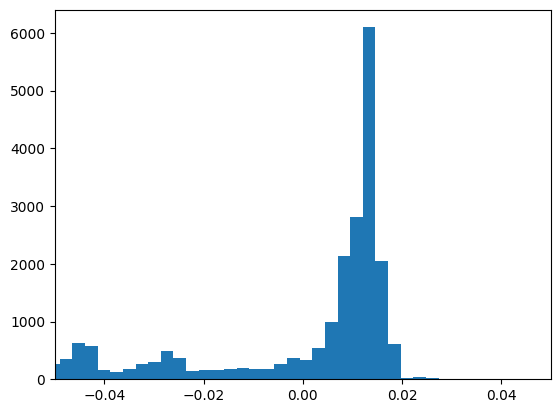

In [31]:
# Plot heights of pen tip above canvas plane as histogram
canvas_p1 = states[:,0]
canvas_p2 = states[:,1]
canvas_p3 = states[:,2]
canvas_normal = np.cross(canvas_p2 - canvas_p1, canvas_p3 - canvas_p1)
canvas_normal = canvas_normal / np.expand_dims(np.linalg.norm(canvas_normal, axis=1), 1)

heights = np.sum((pen_tips - canvas_p1) * canvas_normal, axis=1)

plt.hist(heights, bins=100)
plt.xlim([-0.05, 0.05])
plt.show()

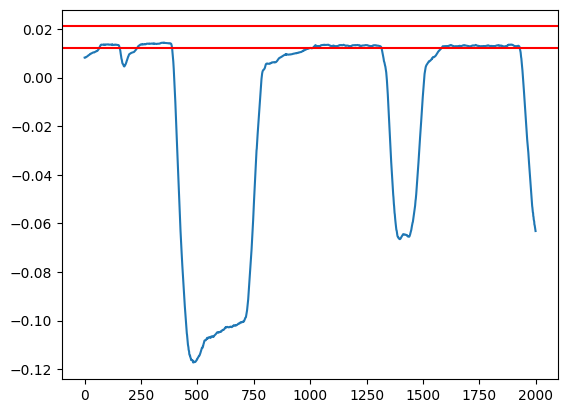

In [32]:
# Plot heights over time
start_time = 10000
time_seconds = 10
end_time = start_time + int(time_seconds/0.005)

plt.plot(heights[start_time:end_time])
# plot horizontal lines at CANVAS_MIN_HEIGHT and CANVAS_MAX_HEIGHT
plt.axhline(CANVAS_MIN_HEIGHT, color='r')
plt.axhline(CANVAS_MAX_HEIGHT, color='r')

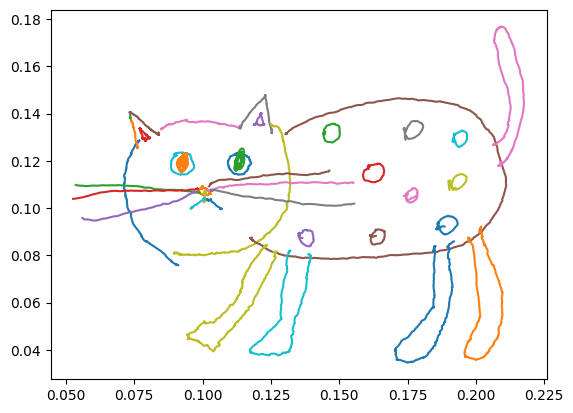

In [33]:
# For each pen tip position, project it onto the canvas plane.
# If the height above the canvas plane is within the range [CANVAS_MIN_HEIGHT, CANVAS_MAX_HEIGHT],
# then the pen tip is considered to be on the canvas. Calculate the canvas coordinates of the pen tip.

touch_positions_global = []
touch_positions_canvas = []
trajectories = []
cur_trajectory = []
for i in range(len(states)):
    tip = pen_tips[i]
    canvas_p1, canvas_p2, canvas_p3 = states[i,0], states[i,1], states[i,2]
    canvas_normal = np.cross(canvas_p2 - canvas_p1, canvas_p3 - canvas_p1)
    canvas_normal = canvas_normal / np.linalg.norm(canvas_normal)
    height = np.dot(tip - canvas_p1, canvas_normal)
    if CANVAS_MIN_HEIGHT <= height <= CANVAS_MAX_HEIGHT:
        middle_corner, side_corners, fourth_corner = get_corners(states[i])
        u1 = side_corners[0] - middle_corner
        u2 = side_corners[1] - middle_corner

        # Calculate pen tip position in basis u1, u2
        x = np.dot(tip - middle_corner, u1) / np.linalg.norm(u1) ** 2
        y = np.dot(tip - middle_corner, u2) / np.linalg.norm(u2) ** 2
        if x < 0 or y < 0 or x > 1 or y > 1:
            continue

        canvas_pos = [x * np.linalg.norm(u1), np.linalg.norm(u2)*(1-y), 0.5]
        global_pos = middle_corner + x*u1 + y*u2

        touch_positions_canvas.append(canvas_pos)
        touch_positions_global.append(global_pos)
        cur_trajectory.append(canvas_pos)
    else:
        touch_positions_canvas.append([None, None, None])
        touch_positions_global.append([None, None, None])
        if len(cur_trajectory) > 0:
            trajectories.append(cur_trajectory)
            cur_trajectory = []
touch_positions_canvas = np.array(touch_positions_canvas)
touch_positions_global = np.array(touch_positions_global)

# Plot each trajectory as a polyline
for trajectory in trajectories:
    plt.plot([p[0] for p in trajectory], [p[1] for p in trajectory], '-')

# Save trajectories
with open(f"mocap_dataset/{data_id}/trajectories.pkl", 'wb') as f:
    pickle.dump(trajectories, f)

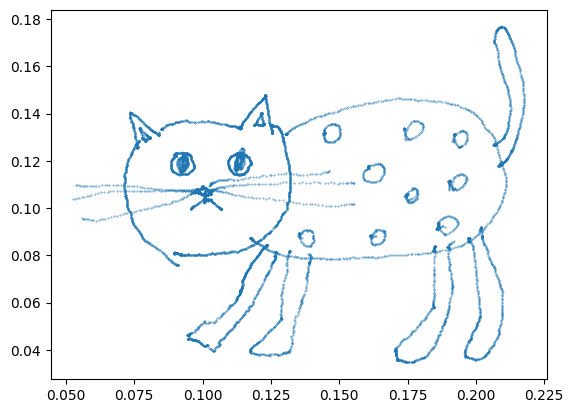

In [34]:
# Scatter plot the touch positions
plt.scatter(touch_positions_canvas[:, 0], touch_positions_canvas[:, 1], s=0.1)

In [35]:
# def plot_state(idx, ax=None):
#     def draw_data(ax, points, lines):
#         # points: each element is (x, y, z, color)
#         # lines: each element is (x1, y1, z1, x2, y2, z2, color)
#         for point in points:
#             ax.scatter(point[0], point[1], point[2], c=point[3])
#         for line in lines:
#             ax.plot([line[0], line[3]], [line[1], line[4]], [line[2], line[5]], c=line[6])

#     preserve_limits = False
#     if ax is None:
#         ax = plt.axes(projection='3d')
#         ax.view_init(vertical_axis='y')
#         fig = ax.figure
#     else:
#         preserve_limits = True
#         fig = ax.figure
#         xlim = ax.get_xlim()
#         ylim = ax.get_ylim()
#         zlim = ax.get_zlim()
#         ax.clear()
#         ax.view_init(vertical_axis='y')
    
#     points = []
#     lines = []

#     # Draw canvas corners
#     middle_corner, side_corners, fourth_corner = get_corners(states[idx])

#     # Middle corner is blue, side corners are light blue, and fourth corner is purple
#     points.append([middle_corner[0], middle_corner[1], middle_corner[2], 'b'])
#     points.append([side_corners[0][0], side_corners[0][1], side_corners[0][2], 'lightblue'])
#     points.append([side_corners[1][0], side_corners[1][1], side_corners[1][2], 'lightblue'])
#     points.append([fourth_corner[0], fourth_corner[1], fourth_corner[2], 'purple'])

#     # Draw black lines connecting canvas corners
#     lines.append([middle_corner[0], middle_corner[1], middle_corner[2], side_corners[0][0], side_corners[0][1], side_corners[0][2], 'k'])
#     lines.append([middle_corner[0], middle_corner[1], middle_corner[2], side_corners[1][0], side_corners[1][1], side_corners[1][2], 'k'])
#     lines.append([fourth_corner[0], fourth_corner[1], fourth_corner[2], side_corners[0][0], side_corners[0][1], side_corners[0][2], 'k'])
#     lines.append([fourth_corner[0], fourth_corner[1], fourth_corner[2], side_corners[1][0], side_corners[1][1], side_corners[1][2], 'k'])

#     # Draw pen points as red, orange, yellow
#     points.append([states[idx,3,0], states[idx,3,1], states[idx,3,2], 'r'])
#     points.append([states[idx,4,0], states[idx,4,1], states[idx,4,2], 'orange'])
#     points.append([states[idx,5,0], states[idx,5,1], states[idx,5,2], 'y'])
#     # Draw pen tip in green
#     points.append([pen_tips[idx,0], pen_tips[idx,1], pen_tips[idx,2], 'g'])

#     # Draw lines between pen points and the tip
#     lines.append([states[idx,3,0], states[idx,3,1], states[idx,3,2], pen_tips[idx,0], pen_tips[idx,1], pen_tips[idx,2], 'k'])
#     lines.append([states[idx,4,0], states[idx,4,1], states[idx,4,2], pen_tips[idx,0], pen_tips[idx,1], pen_tips[idx,2], 'k'])
#     lines.append([states[idx,5,0], states[idx,5,1], states[idx,5,2], pen_tips[idx,0], pen_tips[idx,1], pen_tips[idx,2], 'k'])
#     ax.plot([states[idx,3,0], pen_tips[idx,0]], [states[idx,3,1], pen_tips[idx,1]], [states[idx,3,2], pen_tips[idx,2]], c='k')
#     ax.plot([states[idx,4,0], pen_tips[idx,0]], [states[idx,4,1], pen_tips[idx,1]], [states[idx,4,2], pen_tips[idx,2]], c='k')
#     ax.plot([states[idx,5,0], pen_tips[idx,0]], [states[idx,5,1], pen_tips[idx,1]], [states[idx,5,2], pen_tips[idx,2]], c='k')
#     # Draw lines between pen points
#     lines.append([states[idx,3,0], states[idx,3,1], states[idx,3,2], states[idx,4,0], states[idx,4,1], states[idx,4,2], 'k'])
#     lines.append([states[idx,3,0], states[idx,3,1], states[idx,3,2], states[idx,5,0], states[idx,5,1], states[idx,5,2], 'k'])
#     lines.append([states[idx,4,0], states[idx,4,1], states[idx,4,2], states[idx,5,0], states[idx,5,1], states[idx,5,2], 'k'])

#     # Draw touch position if it is not None
#     if touch_positions_global[idx][0] is not None:
#         points.append([touch_positions_global[idx,0], touch_positions_global[idx,1], touch_positions_global[idx,2], 'k'])
    
#     draw_data(ax, points, lines)

#     if preserve_limits:
#         ax.set_xlim(xlim)
#         ax.set_ylim(ylim)
#         ax.set_zlim(zlim)
#     else:
#         def set_axes_equal(ax: plt.Axes):
#             """Set 3D plot axes to equal scale.

#             Make axes of 3D plot have equal scale so that spheres appear as
#             spheres and cubes as cubes.  Required since `ax.axis('equal')`
#             and `ax.set_aspect('equal')` don't work on 3D.
#             """
#             limits = np.array([
#                 ax.get_xlim3d(),
#                 ax.get_ylim3d(),
#                 ax.get_zlim3d(),
#             ])
#             origin = np.mean(limits, axis=1)
#             radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
#             _set_axes_radius(ax, origin, radius)

#         def _set_axes_radius(ax, origin, radius):
#             x, y, z = origin
#             ax.set_xlim3d([x - radius, x + radius])
#             ax.set_ylim3d([y - radius, y + radius])
#             ax.set_zlim3d([z - radius, z + radius])

#         ax.set_box_aspect([1,1,1])
#         set_axes_equal(ax)

#     return fig, ax

# # Make animation of states
# fig, ax = plot_state(states.shape[0] // 2) # Set axes based on state during middle of painting
# frames = []
# framenum = 0
# if not os.path.exists('tmp'):
#     os.mkdir('tmp')
# for i in tqdm(range(0, states.shape[0], 5)):
#     fig, ax = plot_state(i, ax)
#     fig.savefig(f"tmp/{framenum}.png")
#     framenum += 1

In [36]:
# import moviepy.editor
# image_files = [os.path.join('tmp', f"{i}.png") for i in range(len(os.listdir('tmp')))]
# clip = moviepy.editor.ImageSequenceClip(image_files, fps=24)
# clip.write_videofile(os.path.join("mocap_dataset", "replay.mp4"))